In [1]:
import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from keras import layers as tf_nn
from keras import models

2024-06-05 09:22:48.507958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 09:22:48.508134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 09:22:48.683881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class audio_config:
    audio_folder = '/kaggle/input/audio-sentiment-analysis/Audio_Dataset'
    audio_feature_csv = 'audio_emotions.csv'
    sample_rate = 22000
    cmap = 'inferno'
    num_classes = 6

class Configs:
    # General
    epochs = 35
    lr = 0.001
    batch_size = 32
    
emotion_dict = {
    'hap': 'happy',
    'dis': 'disgusted',
    'ang': 'angry',
    'fea': 'fear',
    'neu': 'neutral',
    'sad': 'sad'
}

In [3]:
def extract_audio_features(audio):
    audio_waveform, sr = librosa.load(
        audio, sr=audio_config.sample_rate, duration=3, offset=0.5
    )

    audio_mel = librosa.feature.mfcc(y=audio_waveform, sr=sr, n_mfcc=50)
    processed_mfcc = np.mean(audio_mel.T, axis=0)

    features = np.array(processed_mfcc)
    return features


In [4]:
def get_audio_files_and_labels(dir):

    for folder, _, filenames in os.walk(dir):
        for file in tqdm(filenames):
            file_path = os.path.join(folder, file)
        
            label = file.split('_')[-1].split('.')[0].lower()
            
            yield (file_path, label)
            
# file_paths, labels = zip(*get_audio_files_and_labels('/kaggle/input/audio-sentiment-analysis/Audio_Dataset'))

In [5]:
def audio_file_csv(audio_files, labels):

    data_for_df = {
        "audio": audio_files,
        "emotion_labels": labels
    }

    feature_df = pd.DataFrame(data_for_df)
    feature_df.to_csv(audio_config.audio_feature_csv, index=False)

    print('Audio features csv creation complete')
    return feature_df

# audio_df = audio_file_csv(file_paths, labels)

In [6]:
# For Audio paths: GEt file paths, labels, then map the extract audio function

file_paths, labels = zip(*get_audio_files_and_labels(audio_config.audio_folder))

audio_df = audio_file_csv(file_paths, labels)

0it [00:00, ?it/s]

  0%|          | 0/1923 [00:00<?, ?it/s]

  0%|          | 0/1923 [00:00<?, ?it/s]

  0%|          | 0/1923 [00:00<?, ?it/s]

  0%|          | 0/1923 [00:00<?, ?it/s]

  0%|          | 0/1923 [00:00<?, ?it/s]

  0%|          | 0/1703 [00:00<?, ?it/s]

Audio features csv creation complete


In [7]:
audio_df.dropna().head()

,audio,emotion_labels
0,/kaggle/input/audio-sentiment-analysis/Audio_D...,hap
1,/kaggle/input/audio-sentiment-analysis/Audio_D...,hap
2,/kaggle/input/audio-sentiment-analysis/Audio_D...,hap
3,/kaggle/input/audio-sentiment-analysis/Audio_D...,hap
4,/kaggle/input/audio-sentiment-analysis/Audio_D...,hap


In [8]:
print(f'Number of audio files: {len(file_paths)}')

Number of audio files: 11318


In [9]:
audio_df['emotion_labels'][2]

'hap'

In [10]:
audio_df["emotion_labels"].unique()

array(['hap', 'ang', 'fea', 'sad', 'dis', 'neu'], dtype=object)

In [11]:
%%time

# Extract audio features and store in numpy array

audio_features = audio_df["audio"].apply(lambda v: extract_audio_features(v)) # type: ignore 

x_audio = [x for x in audio_features]
x_audio = np.array(x_audio)
x_audio = np.expand_dims(x_audio, -1)

print(x_audio.shape)

(11318, 50, 1)
CPU times: user 11min 2s, sys: 10min 24s, total: 21min 27s
Wall time: 6min 11s


In [12]:
# For the labels: replace with complete text, and encode as numbers
encoder = OneHotEncoder()
audio_df["emotion_labels"] = audio_df["emotion_labels"].map(emotion_dict)
print(audio_df["emotion_labels"].unique())

y_labels = encoder.fit_transform(audio_df[["emotion_labels"]])
print(audio_df["emotion_labels"].unique())

y_labels = y_labels.toarray()


print(y_labels.shape)

['happy' 'angry' 'fear' 'sad' 'disgusted' 'neutral']
['happy' 'angry' 'fear' 'sad' 'disgusted' 'neutral']
(11318, 6)


In [13]:
x_audio_train, x_audio_test, y_labels_train, y_labels_test = train_test_split(x_audio, y_labels, test_size=0.15, random_state=123)

x_audio_train.shape, y_labels_train.shape,  x_audio_test.shape, y_labels_test.shape

((9620, 50, 1), (9620, 6), (1698, 50, 1), (1698, 6))

In [14]:
# x_audio_train = np.expand_dims(x_audio_train, axis=2)


In [15]:
input_shape = (x_audio_train.shape[1], x_audio_train.shape[2])

input_shape

(50, 1)

In [16]:

audio_clf = models.Sequential(
    [
#         tf_nn.Input(),
        tf_nn.LSTM(128, return_sequences=False, input_shape=input_shape),# (50, 1)
        tf_nn.Dense(64, activation='relu'),
        tf_nn.Dropout(0.2),
        tf_nn.Dense(16, activation='relu'),
        tf_nn.Dropout(0.2),
        tf_nn.Dense(6, activation='softmax')
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
rlp_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=5, min_lr=0.00001) # type: ignore

audio_clf.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print('Model created ')

Model created 


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
audio_clf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,958 (296.71 KB)

 Trainable params: 75,958 (296.71 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
training = audio_clf.fit(
    x_audio,
    y_labels,
    validation_split=0.1,
    epochs=Configs.epochs,
    batch_size=Configs.batch_size,
    callbacks=[rlp_callback],
)

Epoch 1/35
319/319 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.2543 - loss: 1.6980 - val_accuracy: 0.2323 - val_loss: 2.1073 - learning_rate: 0.0010
Epoch 2/35
319/319 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4114 - loss: 1.4302 - val_accuracy: 0.2314 - val_loss: 2.0938 - learning_rate: 0.0010
Epoch 3/35
319/319 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.4439 - loss: 1.3406 - val_accuracy: 0.2341 - val_loss: 2.0219 - learning_rate: 0.0010
Epoch 4/35
319/319 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.4764 - loss: 1.2874 - val_accuracy: 0.2332 - val_loss: 1.9529 - learning_rate: 0.0010
Epoch 5/35
319/319 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.4844 - loss: 1.2664 - val_accuracy: 0.2297 - val_loss: 1.9765 - learning_rate: 0.0010
Epoch 6/35
319/319 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.4847 - loss: 1.2525 - val_accuracy: 0.2314 - val_loss: 2.0580 - learning_rate: 0.0010
Epoch 7/35
319/319 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.4961 - l

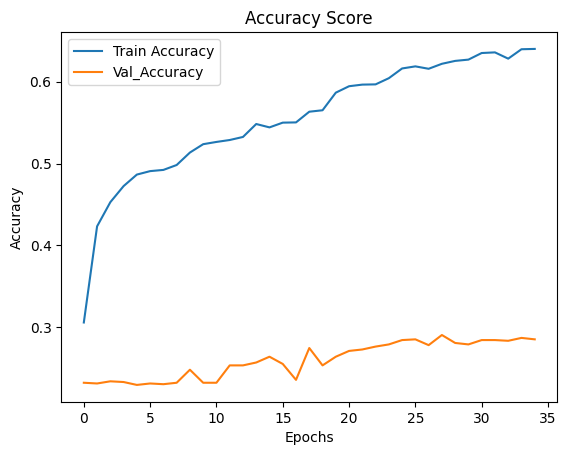

In [19]:
epochs = list(range(35))

accuracy = training.history["accuracy"]
val_accuracy = training.history["val_accuracy"]

plt.plot(epochs , accuracy, label = 'Train Accuracy')
plt.plot(epochs , val_accuracy, label = 'Val_Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Score")
plt.legend()
plt.show()

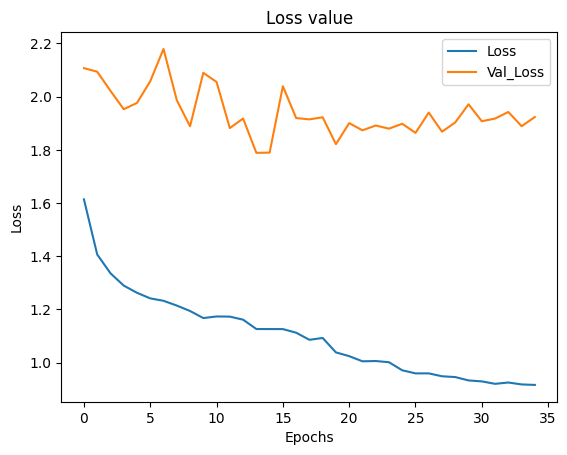

In [20]:
loss = training.history["loss"]
val_loss = training.history["val_loss"]

plt.plot(epochs , loss, label = 'Loss')
plt.plot(epochs , val_loss, label = 'Val_Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss value")
plt.legend()
plt.show()